# Fermionic fields

# Introduction

Fermion fields represent particles obeying Fermi–Dirac statistics and satisfy canonical **anticommutation** relations rather than commutation relations.

Because fermionic operators anticommute, the **giancarlo** library must correctly implement and enforce these rules in all algebraic manipulations.

Dirac fields have four components

$$
    \psi^\alpha(x)
$$

and are created using the `SpinorField` method as shown below.

In [1]:
import giancarlo as gc
gc.PlotStyle.style = 'dark_background'

psi, psibar = gc.SpinorField(r'\psi')

Quark propagators are built by calling the `wick` method on a given expression with fermionic fields, which require not only the position but also a label indicating the spin degree of freedom.

In [2]:
(psi('x','s_a') * psibar('y','s_b')).wick()

( +S_{\psi}(x, y)(s_a, s_b) )

Fermionic fields anticommute

In [3]:
(psibar('x','s_a') * psi('y','s_b')).wick()

( -\,S_{\psi}(y, x)(s_b, s_a) )

The Dirac matrices $\gamma_\mu$ form a set of matrices satisfying the Clifford algebra, used to represent the Lorentz-covariant spinor structure of fermions in relativistic QFTs.

They are implemented by the method `DiracGamma` and they can be inserted in expressions with fermions. At the moment Clifford algebra rules are not implemented and products of Dirac matrices are simplified.

Below we show how to build the quark bilinear

$$
    \overline \psi(x) \gamma_\mu \psi(x)
$$

and we consider the corresponding two-point correlator.

In [4]:
def Current(x, mu):
    sa, sb = gc.default.var(), gc.default.var()
    return psibar(x, sa) * gc.DiracGamma(mu, sa, sb) * psi(x, sb)

expr = (Current('x', r'\mu') * Current('y', r'\nu')).wick()
expr

( +\gamma_{\mu}(x_{1}, x_{2})\,S_{\psi}(x, x)(x_{2}, x_{1})\,\gamma_{\nu}(x_{3}, x_{4})\,S_{\psi}(y, y)(x_{4}, x_{3})+\gamma_{\mu}(x_{1}, x_{2})\,S_{\psi}(x, y)(x_{2}, x_{3})\,\gamma_{\nu}(x_{3}, x_{4})\,S_{\psi}(y, x)(x_{4}, x_{1}) )

The spinorial structures that originate from Wick's contractions can be further simplified by identifying the presence of closed traces, e.g. over the spin index.

In [5]:
expr.trace(['spin'])

( +\mathrm{Tr}_\mathrm{spin} [ \gamma_{\mu}\,S_{\psi}(x, x) ]\,\mathrm{Tr}_\mathrm{spin} [ \gamma_{\nu}\,S_{\psi}(y, y) ]+\mathrm{Tr}_\mathrm{spin} [ \gamma_{\mu}\,S_{\psi}(x, y)\,\gamma_{\nu}\,S_{\psi}(y, x) ] )

Without any argument the `trace` method does not perform any operation

In [6]:
expr.trace()

( + [ \gamma_{\mu}(x_{1}, x_{2})\,S_{\psi}(x, x)(x_{2}, x_{1})\,\gamma_{\nu}(x_{3}, x_{4})\,S_{\psi}(y, y)(x_{4}, x_{3}) ]+ [ \gamma_{\mu}(x_{1}, x_{2})\,S_{\psi}(x, y)(x_{2}, x_{3})\,\gamma_{\nu}(x_{3}, x_{4})\,S_{\psi}(y, x)(x_{4}, x_{1}) ] )

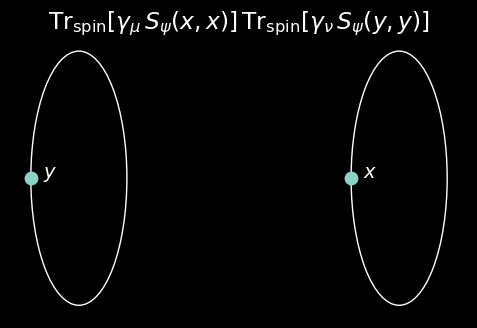

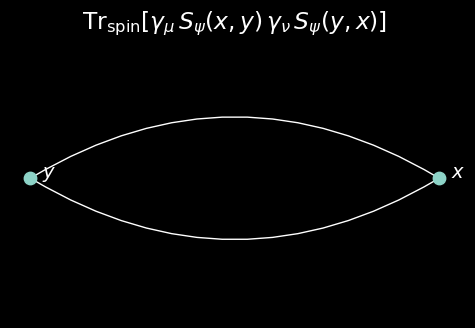

In [7]:
expr.trace(['spin']).draw()

# Electromagnetic current

In the Standard Model of particle physics, the **electromagnetic current** is the conserved quantum current associated with the electromagnetic $U(1)$ gauge symmetry. 
It describes how charged fermion fields couple to the electromagnetic gauge field and it is defined as

$$
J^\mu_\gamma = \sum_f Q_f \, \bar{\psi}_f \gamma^\mu \psi_f ,
$$

where:
- the sum runs over all charged fermion fields $f$,
- $Q_f$ is the electric charge of fermion $f$ in units of the electron charge,
- $\psi_f$ is the fermion field,
- $\gamma^\mu$ are the Dirac gamma matrices.


In [8]:
Q = []
psi = []
psibar = []
Nf = 2

for i in range(Nf):
    Q.append(gc.Symbol(f'Q_{i}'))
    p, pb = gc.SpinorField(rf'\psi_{i}')
    psi.append(p)
    psibar.append(pb)

def J(x, mu):
    a, b = gc.default.var(), gc.default.var()
    terms = []
    for i in range(Nf):
        terms.append(Q[i] * psibar[i](x, a) * gc.DiracGamma(mu, a, b) * psi[i](x, b))
    sum = terms[0]
    for t in terms[1:]:
        sum = sum + t
    return sum

J('x', r'\mu')

( +Q_0\,\bar{\psi_0}(x, x_{5})\,G(\mu, x_{5})\,G(\mu, x_{6})\,\psi_0(x, x_{6})+Q_1\,\bar{\psi_1}(x, x_{5})\,G(\mu, x_{5})\,G(\mu, x_{6})\,\psi_1(x, x_{6}) )

The simplest manner to introduce currents or more complicated operators is via functions, as above. However when we consider the insertion of two EM currents, which we imagine to be summed over the entire space-time it is very convenient to specify the corresponding exchange symmetry.

Contrary to scalar QED, here we have to take into consideration the spin index which is internally summed between the Dirac matrix $\gamma_\mu$ and the spinorial fields

$$
    [\overline \psi(x)]^\alpha [\gamma_\mu]_{\alpha\beta} [\psi(x)]_\beta
$$

To implement the exchange symmetry correctly we must specify also the exchange between $\alpha,\beta$ and $\alpha',\beta'$ where the latter belong to a second insertion of the current.

This is better achieved by introducing a class.

In [9]:
A = gc.PhotonField()

class J:
    def __init__(self, x, mu):
        sa, sb = gc.default.var(), gc.default.var()
        self.sa = sa
        self.sb = sb
        self.x = x
        self.mu = mu
    
    def __call__(self):
        terms = []
        for i in range(Nf):
            terms.append(Q[i] * psibar[i](self.x, self.sa) * gc.DiracGamma(self.mu, self.sa, self.sb) * A(self.x, self.mu) * psi[i](self.x, self.sb))
        sum = terms[0]
        for t in terms[1:]:
            sum = sum + t
        return sum

In [10]:
J1 = J('z_1', r'\alpha')
J2 = J('z_2', r'\beta')

syms = []
syms.append(gc.ExchangeSymmetry(pos=['z_1', 'z_2'], lorentz=[r'\alpha',r'\beta']))
syms.append(gc.ExchangeSymmetry(spin=[J1.sa, J2.sa]))
syms.append(gc.ExchangeSymmetry(spin=[J1.sb, J2.sb]))

By assuming that the various fermions introduced are degenerate we can further simplify our expressions.

This is achieved at the level of the propagators, only after the Wick contractions, by the function replace.

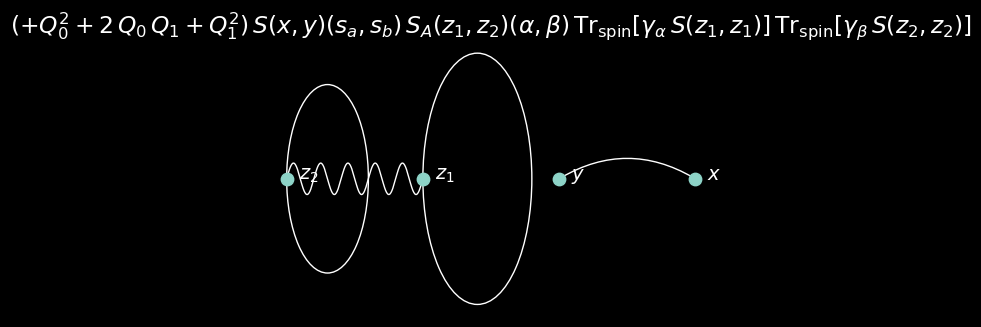

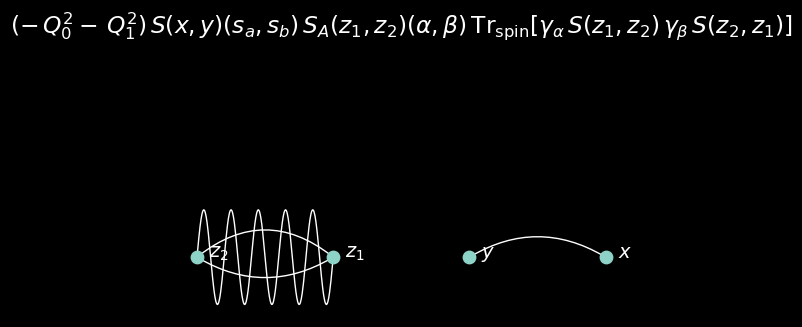

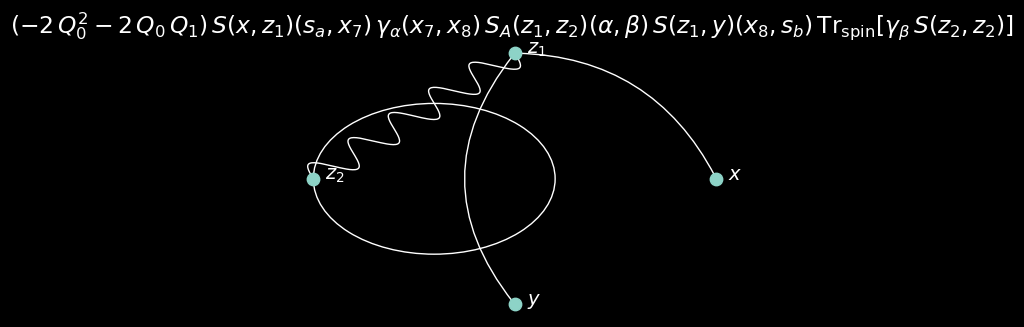

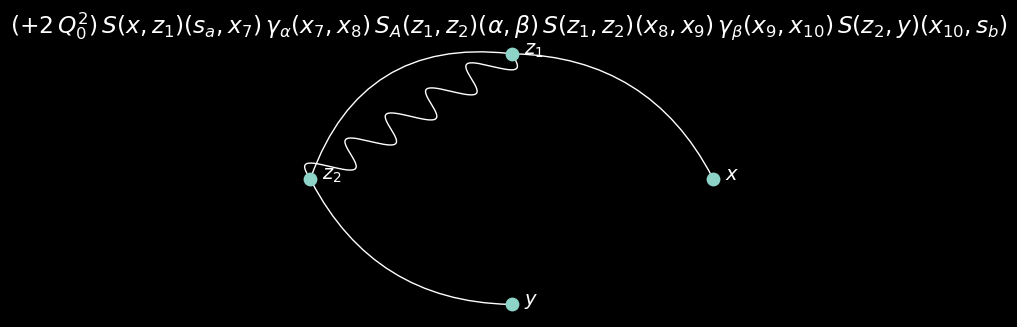

In [11]:
qprop = psi[0]('x', 's_a') * psibar[0]('y', 's_b') * J1() * J2()
qprop.wick().replace({r'S_{\psi_0}': 'S', r'S_{\psi_1}': 'S'}).simplify(*syms).trace(['spin']).draw()

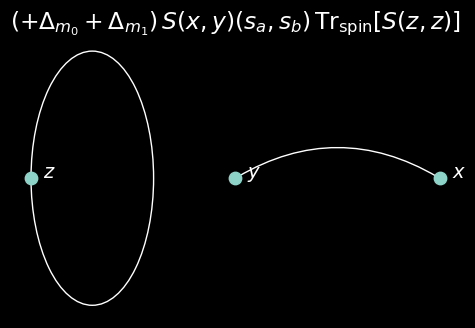

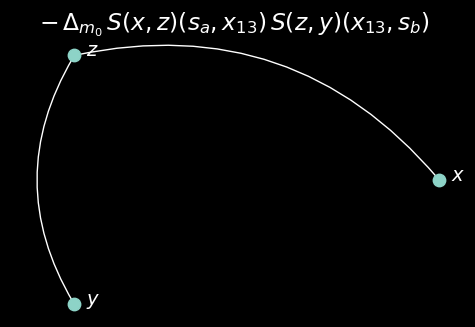

In [14]:
dm = [gc.Symbol(fr'\Delta_{{m_{i}}}') for i in range(Nf)]

def Scalar(x):
    s = gc.default.var()
    terms = []
    for i in range(Nf):
        terms.append(gc.CNumber(-1) * dm[i] * psibar[i](x, s) * psi[i](x, s))
    sum = terms[0]
    for t in terms[1:]:
        sum = sum + t
    return sum

qprop = psi[0]('x', 's_a') * psibar[0]('y', 's_b') * Scalar('z')
qprop.wick().replace({r'S_{\psi_0}': 'S', r'S_{\psi_1}': 'S'}).simplify(*syms).trace(['spin']).draw()